# Laboratorio 7

## Manuel Archila - 161250

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [2]:
path = './malimg_paper_dataset_imgs/'

In [3]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [4]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [5]:
imgs, labels = next(familias)

In [6]:
imgs.shape

(9339, 64, 64, 3)

In [7]:
labels.shape

(9339, 25)

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

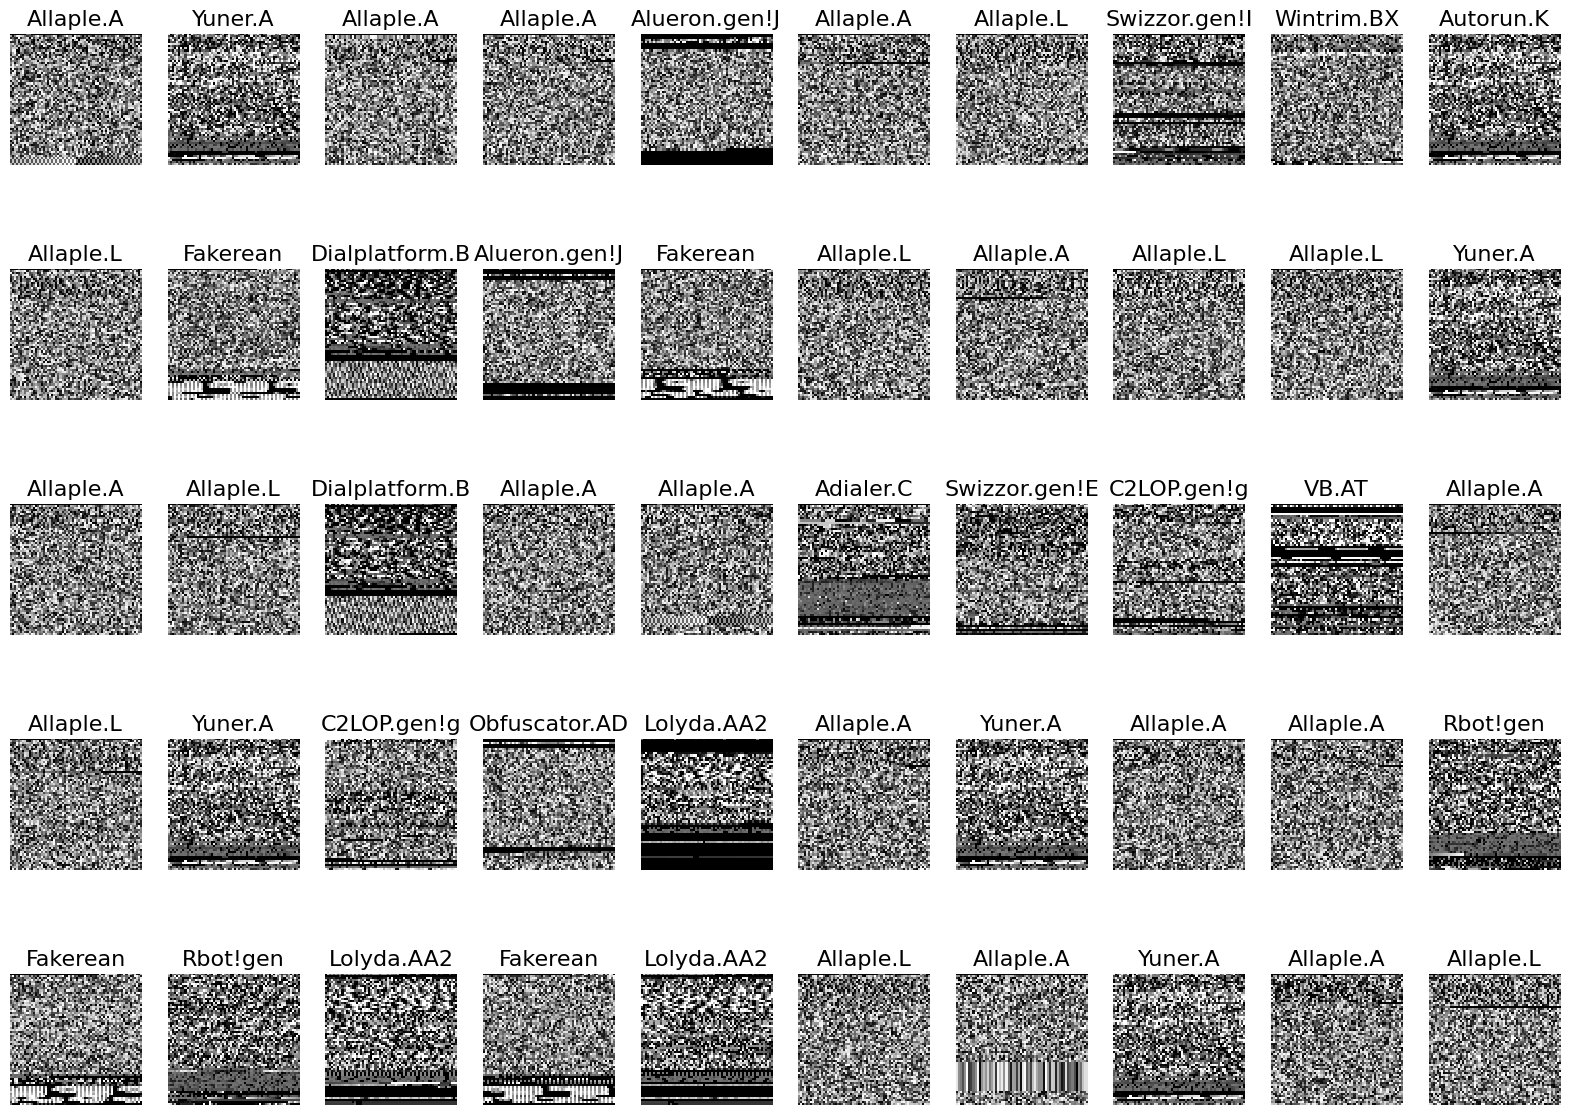

In [9]:

plots(imgs, titles = labels)

In [10]:
# Path al directorio con las imágenes
path = './malimg_paper_dataset_imgs/'

# Crear un generador de datos con escalamiento de las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde el directorio
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Obtener las etiquetas de las clases del generador
class_indices = generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Contar el número de imágenes por clase
for _, labels in generator:
    for label in labels:
        class_name = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_name] += 1
    if generator.batch_index == 0:
        break  # Romper el ciclo después de procesar todas las imágenes una vez

# Mostrar el conteo de cada clase
print("Conteo de observaciones por familia de malware:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Found 9339 images belonging to 25 classes.
Conteo de observaciones por familia de malware:
Adialer.C: 122
Agent.FYI: 116
Allaple.A: 2949
Allaple.L: 1591
Alueron.gen!J: 198
Autorun.K: 106
C2LOP.P: 146
C2LOP.gen!g: 200
Dialplatform.B: 177
Dontovo.A: 162
Fakerean: 381
Instantaccess: 431
Lolyda.AA1: 213
Lolyda.AA2: 184
Lolyda.AA3: 123
Lolyda.AT: 159
Malex.gen!J: 136
Obfuscator.AD: 142
Rbot!gen: 158
Skintrim.N: 80
Swizzor.gen!E: 128
Swizzor.gen!I: 132
VB.AT: 408
Wintrim.BX: 97
Yuner.A: 800


## Primera Parte

### Dividiendo los datos

In [11]:
all_images = []
all_labels = []

# Cargando todas las imágenes y etiquetas
for _ in range(generator.samples // generator.batch_size + 1):
    imgs, labels = next(generator)
    all_images.append(imgs)
    all_labels.append(labels)

# Concatenando todas las imágenes y etiquetas en un solo array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(all_images.shape)
print(all_labels.shape)

# Asegurándose de no tener más datos de los necesarios
all_images = all_images[:generator.samples]
all_labels = all_labels[:generator.samples]

(9339, 64, 64, 3)
(9339, 25)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)


In [13]:
y_train.shape

(6537, 25)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir la arquitectura del modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar el modelo en los datos de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
164/164 [==============================] - 8s 46ms/step - loss: 1.8223 - accuracy: 0.4496 - val_loss: 0.9850 - val_accuracy: 0.6651
Epoch 2/10
164/164 [==============================] - 8s 51ms/step - loss: 0.9844 - accuracy: 0.6653 - val_loss: 0.7363 - val_accuracy: 0.8410
Epoch 3/10
164/164 [==============================] - 8s 46ms/step - loss: 0.6761 - accuracy: 0.8000 - val_loss: 0.3325 - val_accuracy: 0.9083
Epoch 4/10
164/164 [==============================] - 7s 45ms/step - loss: 0.4409 - accuracy: 0.8719 - val_loss: 0.2641 - val_accuracy: 0.9190
Epoch 5/10
164/164 [==============================] - 7s 45ms/step - loss: 0.3782 - accuracy: 0.8898 - val_loss: 0.2194 - val_accuracy: 0.9297
Epoch 6/10
164/164 [==============================] - 7s 45ms/step - loss: 0.2972 - accuracy: 0.9099 - val_loss: 0.2095 - val_accuracy: 0.9297
Epoch 7/10
164/164 [==============================] - 7s 45ms/step - loss: 0.2483 - accuracy: 0.9212 - val_loss: 0.1748 - val_accuracy: 0.9434

In [15]:
model.save('modelo_victima.h5')

c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Segunda Parte

## Ataque de Evasion

In [16]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

# Convertir el modelo de TensorFlow en un modelo compatible con ART
classifier = TensorFlowV2Classifier(model=model, nb_classes=25, input_shape=(64, 64, 3), loss_object=tf.keras.losses.CategoricalCrossentropy())

# Crear el objeto de ataque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)  # eps controla la magnitud de la perturbación

# Generar ejemplos adversarios
X_test_adv = attack.generate(x=X_test)

# Evaluar el modelo en los ejemplos adversarios
predictions = classifier.predict(X_test_adv)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))

print(f"Accuracy en ejemplos adversarios: {accuracy*100:.2f}%")
print(f"Accuracy en ejemplos originales: {test_acc*100:.2f}%")

c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


Accuracy en ejemplos adversarios: 7.57%
Accuracy en ejemplos originales: 95.22%


##### ¿Qué es?
El FGSM es una técnica de ataque diseñada para engañar a los modelos de aprendizaje automático modificando ligeramente los datos de entrada de manera que el modelo haga predicciones incorrectas. Es un tipo de ataque de adversario que busca explotar vulnerabilidades en la forma en que el modelo procesa sus entradas.

##### ¿Cómo funciona?

Cálculo del Gradiente: El ataque comienza con el cálculo del gradiente de la pérdida del modelo con respecto a la entrada (por ejemplo, una imagen). Este gradiente indica en qué dirección cambiar la entrada para aumentar la pérdida, lo que probablemente conducirá a una predicción incorrecta.
Perturbación Adversaria: Se añade una pequeña perturbación a la entrada original en la dirección del signo del gradiente. Esta perturbación es diseñada para ser mínima pero suficiente para engañar al modelo.
Evaluación: La entrada modificada se pasa al modelo, y si el modelo la clasifica incorrectamente, el ataque se considera exitoso.

## Ataque de Extraccion

In [17]:
import tensorflow as tf
from art.attacks.extraction import CopycatCNN
from art.estimators.classification import TensorFlowV2Classifier

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy()

target_classifier = TensorFlowV2Classifier(
    model=model, 
    nb_classes=25,
    input_shape=(64, 64, 3),
    loss_object=loss_object,
    optimizer=optimizer
)

student_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax')
])

student_classifier = TensorFlowV2Classifier(
    model=student_model,
    nb_classes=25,
    input_shape=(64, 64, 3),
    loss_object=loss_object,
    optimizer=optimizer
)

attack = CopycatCNN(
    classifier=target_classifier,
    batch_size_query=1,
    nb_epochs=10,
    nb_stolen=1000
)

stolen_data = attack.extract(x=X_test, y=None, thieved_classifier=student_classifier)

In [18]:

student_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

test_loss_student, test_acc_student = student_model.evaluate(X_test, y_test)
print(f"Accuracy del modelo estudiante con los datos de prueba originales: {test_acc_student*100:.2f}%")
print(f"Accuracy del modelo original: {test_acc*100:.2f}%")


88/88 [==============================] - 1s 8ms/step - loss: 1.4046 - accuracy: 0.9236
Accuracy del modelo estudiante con los datos de prueba originales: 92.36%
Accuracy del modelo original: 95.22%


##### ¿Qué es?
Un ataque de extracción de modelo tiene como objetivo replicar el modelo de aprendizaje automático de un sistema, utilizando sólo acceso a las predicciones del modelo (por ejemplo, a través de una API). Este tipo de ataque puede ser utilizado para robar propiedad intelectual, para descubrir información sobre los datos sobre los que fue entrenado el modelo, o para facilitar otros tipos de ataques, como los de evasión.

##### ¿Cómo funciona?

Interrogación del Modelo: El atacante envía múltiples consultas al modelo objetivo y recopila las predicciones.
Reconstrucción del Modelo: Utilizando los datos de entrada y las predicciones obtenidas, el atacante entrena un nuevo modelo (el modelo "estudiante") que intenta replicar las decisiones del modelo original.
Validación: Finalmente, el atacante evalúa cuán cercanamente el modelo estudiante imita al modelo original, comparando sus respuestas en un conjunto de datos de prueba.
Este ataque explota el hecho de que muchos modelos de aprendizaje automático son fundamentalmente "cajas negras" que pueden ser aproximadas si se puede observar suficientemente su comportamiento en un número suficiente de casos.

# Laboratorio 8

### Defensa contra ataque de evasión

In [21]:
import tensorflow as tf
import numpy as np
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

def adversarial_training(model, x_train, y_train, epsilons, ratio=0.5):
    for eps in epsilons:
        attack = FastGradientMethod(estimator=classifier, eps=eps)
        x_train_adv = attack.generate(x=x_train)
        x_combined = np.vstack((x_train, x_train_adv[:int(len(x_train) * ratio)]))
        y_combined = np.vstack((y_train, y_train[:int(len(y_train) * ratio)]))
        indices = np.random.permutation(len(x_combined))
        x_combined, y_combined = x_combined[indices], y_combined[indices]
        model.fit(x_combined, y_combined, epochs=1, batch_size=32)  # Ejecutar cada epoch con diferente eps

# Variar eps en un rango, por ejemplo, [0.05, 0.1, 0.2]
adversarial_training(model, X_train, y_train, epsilons=[0.05, 0.1, 0.2])

x_test_adv = attack.generate(x=X_test)
test_loss_adv, test_acc_adv = model.evaluate(x_test_adv, y_test)
print(f"Accuracy en ejemplos adversarios: {test_acc_adv*100:.2f}%")


88/88 [==============================] - 1s 12ms/step - loss: 0.2888 - accuracy: 0.9065
Accuracy en ejemplos adversarios: 90.65%


El accuracy del modelo entrenado con el método de defensa adversaria es de 90.65%, lo cual es un valor mejor que el accuracy del modelo sin defensa adversaria, que es de 7.57%. Esto indica que la defensa adversaria ha sido efectiva para mejorar la capacidad del modelo de generalizar y hacer predicciones precisas en ejemplos adversarios.

La defensa contra ataques adversarios se implementa mediante la técnica de entrenamiento adversario. Este enfoque consiste en generar ejemplos adversarios utilizando el método Fast Gradient Sign Method (FGSM), un tipo de ataque de evasión, y luego mezclar estos ejemplos con los datos de entrenamiento normales. La intensidad de las perturbaciones generadas se controla a través del parámetro eps, que se varía durante el entrenamiento para exponer al modelo a un rango de perturbaciones. Esta estrategia tiene como objetivo hacer que el modelo sea más robusto al aprender no solo de datos limpios sino también de datos perturbados, preparándolo mejor para reconocer y manejar correctamente ejemplos adversarios durante su uso práctico. Al entrenar de esta manera, el modelo desarrolla una mejor capacidad para generalizar desde ejemplos perturbados, aumentando así su resistencia a ataques similares en situaciones reales.

### Defensa contra ataque de extracción

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.extraction import CopycatCNN
from sklearn.metrics import accuracy_score

def add_noise_to_output(output):
    noise = tf.random.normal(shape=tf.shape(output), mean=0.0, stddev=0.01)
    return output + noise

# Define la arquitectura del modelo con la capa de ruido
target_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax'),
    Lambda(add_noise_to_output)  # Añade ruido directamente en el modelo
])

# Crear el clasificador con el modelo protegido
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy()
target_classifier = TensorFlowV2Classifier(
    model=target_model,
    nb_classes=25,
    input_shape=(64, 64, 3),
    loss_object=loss_object,
    optimizer=optimizer
)

# Define el modelo del estudiante para el ataque
student_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(25, activation='softmax')
])

student_classifier = TensorFlowV2Classifier(
    model=student_model,
    nb_classes=25,
    input_shape=(64, 64, 3),
    loss_object=loss_object,
    optimizer=optimizer
)

# Configurar y realizar el ataque de extracción
attack = CopycatCNN(
    classifier=target_classifier,
    batch_size_query=1,
    nb_epochs=10,
    nb_stolen=1000
)

stolen_data = attack.extract(x=X_test, y=None, thieved_classifier=student_classifier)

predictions = student_classifier.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy of the student model: {:.2f}%".format(accuracy * 100))


Accuracy of the student model: 4.25%


El accuracy del student model original es de 95.22%, mientras que el accuracy del student model con el cual se implementó la defensa adversaria es de 4.25%. Esto indica que la introduccion de ruido en las predicciones del modelo ha sido efectiva para protegerlo contra el ataque de extracción CopycatCNN.

Para proteger el modelo del ataque de extracción CopycatCNN, se implementó una estrategia de defensa basada en la adición de ruido a las predicciones del modelo. Esto se logró mediante la incorporación de una capa Lambda en la arquitectura del modelo de red neuronal, la cual aplica una perturbación aleatoria normal (gaussiana) a la salida del modelo. El objetivo de esta capa de ruido es modificar ligeramente las respuestas del modelo para cada consulta, haciendo que sea mucho más difícil para un atacante extraer con precisión el comportamiento del modelo original. El ruido tiene una media de cero y una desviación estándar pequeña, lo cual asegura que las modificaciones sean sutiles y no afecten significativamente la precisión del modelo en operaciones legítimas.